In [1]:
import re
import os
import sys
import h5py
import time
import numpy as np
import scipy as sp
from utils import *
import mindspore as ms
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindspore.common.initializer import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from scipy.linalg import expm, sqrtm, block_diag
from numpy.linalg import det, svd, eigh, norm, matrix_rank

np.set_printoptions(linewidth=200)

0.9040304304142199 0.9494012656337687 -0.08682217832491834
[0.63899142+0.08698783j 0.06118549+0.20000549j 0.30801998+0.66745855j]
[[0.64246606+0.76497076j 0.        +0.j         0.        +0.j         0.0347312 -0.02916924j]
 [0.        +0.j         0.21356049+0.17936028j 0.61761102-0.73537639j 0.        +0.j        ]
 [0.        +0.j         0.61761102-0.73537639j 0.21356049+0.17936028j 0.        +0.j        ]
 [0.0347312 -0.02916924j 0.        +0.j         0.        +0.j         0.64246606+0.76497076j]]
True


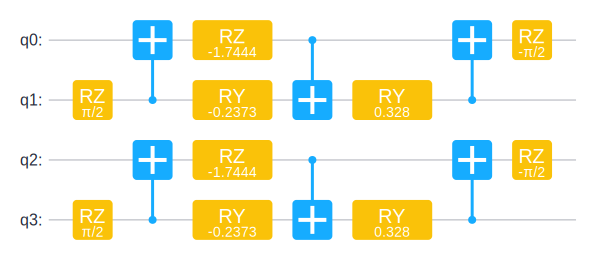

In [22]:
def ESP_ansatz(x, y, z, q0, q1):
    circ = Circuit()
    circ += RZ(np.pi / 2).on(q1)
    circ += X(q0, q1)
    circ += RZ(2 * z - np.pi / 2).on(q0)
    circ += RY(np.pi / 2 - 2 * x).on(q1)
    circ += X(q1, q0)
    circ += RY(2 * y - np.pi / 2).on(q1)
    circ += X(q0, q1)
    circ += RZ(-np.pi / 2).on(q0)
    return circ


x, y, z = np.random.uniform(-1, 1, 3)
print(x, y, z)
# circ = Circuit() + X(0) + X(1) + H(0) + X(1, 0)
circ = ESP_ansatz(x, y, z, 0, 1) + ESP_ansatz(x, y, z, 2, 3)
d = circ.n_qubits
sim = Simulator('mqvector', circ.n_qubits)
qudit = np.random.rand(3) + 1j * np.random.rand(3)
qudit /= norm(qudit)
print(qudit)
# qubit = su2_encoding(qudit)
# sim.set_qs(qubit)
# # print(sim.get_qs())
# sim.apply_circuit(circ)
# print(sim.get_qs())
# print(is_symmetric(sim.get_qs(), 2))
print(ESP_ansatz(x, y, z, 0, 1).matrix())
print(np.allclose(circ.matrix(), circ.matrix().T))
circ.svg()


In [66]:
# Qudit
d = 3
nq = d - 1
n = 2**nq
for i in range(d):
    for j in range(d):
        a = f'a{str(i)}{str(j)}|{str(i)}⟩⟨{str(j)}|'
        print(a, end=' ')
    print()
print()
# Qubit
for i in range(n):
    for j in range(n):
        ii = bin(i)[2:].zfill(nq)
        jj = bin(j)[2:].zfill(nq)
        a = f'a{str(i)}{str(j)}|{ii}⟩⟨{jj}|'
        print(a, end=' ')
    print()

a00|0⟩⟨0| a01|0⟩⟨1| a02|0⟩⟨2| 
a10|1⟩⟨0| a11|1⟩⟨1| a12|1⟩⟨2| 
a20|2⟩⟨0| a21|2⟩⟨1| a22|2⟩⟨2| 

a00|00⟩⟨00| a01|00⟩⟨01| a02|00⟩⟨10| a03|00⟩⟨11| 
a10|01⟩⟨00| a11|01⟩⟨01| a12|01⟩⟨10| a13|01⟩⟨11| 
a20|10⟩⟨00| a21|10⟩⟨01| a22|10⟩⟨10| a23|10⟩⟨11| 
a30|11⟩⟨00| a31|11⟩⟨01| a32|11⟩⟨10| a33|11⟩⟨11| 


In [93]:
# Qudit
d = 4
nq = d - 1
n = 2**nq
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(i)}{str(j)}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')
print()
# Qubit
ind = {}
for i in range(n):
    num1 = bin(i).count('1')
    ind[i] = [num1]
print(ind)
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(ind[i][0])}{str(ind[j][0])}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')

\begin{pmatrix}
a_{00} & a_{01} & a_{02} & a_{03} \\
a_{10} & a_{11} & a_{12} & a_{13} \\
a_{20} & a_{21} & a_{22} & a_{23} \\
a_{30} & a_{31} & a_{32} & a_{33} \\
\end{pmatrix}

{0: [0], 1: [1], 2: [1], 3: [2], 4: [1], 5: [2], 6: [2], 7: [3]}
\begin{pmatrix}
a_{00} & a_{01} & a_{01} & a_{02} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{20} & a_{21} & a_{21} & a_{22} \\
\end{pmatrix}


In [ ]:
for i in range(d):
    for j in range(d):
        a = 'aij|x⟩⟨y|'.replace('i', str(i)).replace('j', str(j))
        a = a.replace('x', np.base_repr(i, d)).replace('y', np.base_repr(j, d))
        print(a, end=' ')
    print()
print()

In [3]:
d = 3
n = 2**(d - 1)
a1 = unitary_group.rvs(d)
a2 = su2_encoding(a1)
print(a1)
print(a2)
p = np.eye(n) - su2_encoding(np.eye(d))
print(p)
a2 += p
is_unitary(a2), is_symmetric(a2)

[[ 0.08516211-0.44598598j -0.61150151+0.51026305j -0.34994812+0.19255586j]
 [-0.07625552-0.78463319j  0.40702641-0.27245883j -0.26884638-0.25759109j]
 [ 0.09643167+0.40383252j  0.31396014+0.16499166j -0.83519723-0.06536507j]]
[[ 0.08516211-0.44598598j -0.43239686+0.36081046j -0.43239686+0.36081046j -0.34994812+0.19255586j]
 [-0.0539208 -0.55481945j  0.2035132 -0.13622941j  0.2035132 -0.13622941j -0.1901031 -0.1821444j ]
 [-0.0539208 -0.55481945j  0.2035132 -0.13622941j  0.2035132 -0.13622941j -0.1901031 -0.1821444j ]
 [ 0.09643167+0.40383252j  0.22200335+0.11666672j  0.22200335+0.11666672j -0.83519723-0.06536507j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, False)

In [100]:
d = 3
n = 2**(d - 1)
i1 = np.eye(d)
i2 = su2_encoding(i1)
p = np.eye(n) - su2_encoding(np.eye(d))
print(i1)
print(i2)
print(p)
is_symmetric(i2), matrix_rank(i2)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, 3)

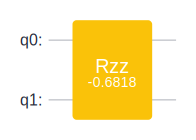

(True, True, True)

In [5]:
# U2⊗U2 Rxx Ryy Rzz SWAP preserve symmetry
d = 3
a1 = unitary_group.rvs(d)
b1 = np.random.rand(d) + 1j * np.random.rand(d)
b1 /= norm(b1)
a2 = su2_encoding(a1)
b2 = su2_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [6]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034+0.j         0.40977999+0.24334959j]
 [0.40977999-0.24334959j 0.65119966+0.j        ]]
[[0.03454462+0.j         0.0930421 -0.15714469j]
 [0.0930421 +0.15714469j 0.96545538+0.j        ]]
[[ 1.20491735e-02+0.j          3.24531155e-02-0.05481212j  1.41556919e-02+0.00840642j  7.63678855e-02-0.04175299j]
 [ 3.24531155e-02+0.05481212j  3.36751167e-01+0.j         -1.14305675e-04+0.0870365j   3.95624296e-01+0.23494318j]
 [ 1.41556919e-02-0.00840642j -1.14305675e-04-0.0870365j   2.24954416e-02+0.j          6.05889828e-02-0.10233257j]
 [ 7.63678855e-02+0.04175299j  3.95624296e-01-0.23494318j  6.05889828e-02+0.10233257j  6.28704218e-01+0.j        ]]
(1.0000000000000007+0j)


1.0000000000000002